In [1]:
import tarfile
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
from PIL import Image
import wandb
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn import preprocessing
import torch.nn as nn
import scipy.io
import pandas as pd
import numpy as np

C:\Users\taran\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()
wandb.init(project="SML", entity="iiit-d")

wandb: Currently logged in as: tarang22081 (iiit-d). Use `wandb login --relogin` to force relogin


In [3]:
from pytorch_pretrained_vit import ViT

# Define the ViT model architecture
model = ViT('B_16', num_classes=1000, pretrained=True)

# Modify the last layer to output 397 classes
model.fc = nn.Linear(model.fc.in_features, 200)

Loaded pretrained weights.


In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name[:3]: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self._get_images()

    def _get_images(self):
        images = []
        # print(self.class_to_idx)
        for class_folder in self.classes:
            class_path = os.path.join(self.root_dir, class_folder)
            class_idx = self.class_to_idx[class_folder[:3]]
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Example usage
root_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\train'
test_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\test'
train_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\new_train'
val_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\new_val'
trans = tt.Compose([
    tt.ToTensor(),tt.Resize((224,224)),tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))   
])

trans_aug = tt.Compose([
   tt.ToTensor(), tt.Resize((224,224)),
    tt.Grayscale(num_output_channels=3), tt.RandomHorizontalFlip(),
   tt.RandomRotation(degrees=20), tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])


In [5]:
# train_dataset = CustomDataset(root_dir, transform=trans)
train_ds = CustomDataset(train_dir, transform=trans_aug)
val_ds = CustomDataset(val_dir, transform=trans)
test_ds = CustomDataset(test_dir, transform=trans)

In [6]:
batch = 6

In [7]:
train_dl = DataLoader(train_ds,batch, shuffle=True)
val_dl = DataLoader(val_ds,batch, shuffle=True)
test_dl = DataLoader(test_ds,batch, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


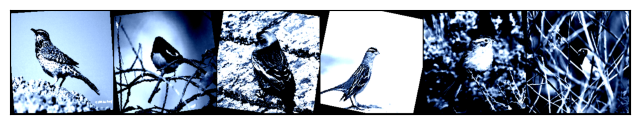

In [8]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))
    

def show_batch(dl, nmax=64):
    for images, label in dl:
        show_images(images, nmax)
        break
show_batch(train_dl,64)

In [9]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == (labels)).item() / len(preds))


class Model(nn.Module):
  def __init__(self ):
    super().__init__()
    self.network =model

  def forward(self, x):
    return self.network(x)
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred,label)
      return loss
  
  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred, label)  
      acc = accuracy(pred, label)
      return {'acc':acc , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]}, accuracy: {result["valid_acc"]}')

In [11]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs,momentum):
  history = []
  optimizer =  optim(model.parameters(),lr=lr,momentum=0.9)
  count = 0
  for epoch in tqdm(range(epochs)):
    train_loss = []
    model.train()
    for batch in train_dl:
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      
      train_loss.append(loss.item())
      optimizer.step()
      # print(count)
      count+=1
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

In [12]:
model = Model()
model = to_device(model,'cuda')
lr = 0.001
momentum =.9
optimizer= torch.optim.SGD
epochs=30
wandb.config = {'lr':lr,'optimuzer':'SGD','epochs':epochs,'batch_size':batch}

In [13]:
# wandb.watch(model)
history=fit(train_dl,val_dl,model,lr,optimizer,epochs,momentum)

  3%|██▋                                                                             | 1/30 [06:51<3:19:05, 411.90s/it]

epoch :1, training loss: 5.1881234756250105, validation loss: 4.998890056610107, accuracy: 0.2566666603088379


  7%|█████▎                                                                          | 2/30 [13:10<3:03:04, 392.31s/it]

epoch :2, training loss: 4.680220091298167, validation loss: 4.306618468761444, accuracy: 0.39666664600372314


 10%|████████                                                                        | 3/30 [19:37<2:55:23, 389.75s/it]

epoch :3, training loss: 3.7415278969479444, validation loss: 3.170915505886078, accuracy: 0.46666663885116577


 13%|██████████▋                                                                     | 4/30 [25:59<2:47:33, 386.67s/it]

epoch :4, training loss: 2.700651511829696, validation loss: 2.2702528858184814, accuracy: 0.5158333778381348


 17%|█████████████▎                                                                  | 5/30 [32:21<2:40:29, 385.18s/it]

epoch :5, training loss: 2.0401732083106965, validation loss: 1.7864289739727974, accuracy: 0.5866667032241821


 20%|████████████████                                                                | 6/30 [38:43<2:33:39, 384.16s/it]

epoch :6, training loss: 1.6704069228285692, validation loss: 1.586863429248333, accuracy: 0.5975000262260437


 23%|██████████████████▋                                                             | 7/30 [45:06<2:27:06, 383.77s/it]

epoch :7, training loss: 1.4266838775632975, validation loss: 1.4174246829748154, accuracy: 0.6175000071525574


 27%|█████████████████████▎                                                          | 8/30 [51:29<2:20:31, 383.27s/it]

epoch :8, training loss: 1.1560450756878071, validation loss: 1.5640340915322304, accuracy: 0.5891667008399963


 30%|████████████████████████                                                        | 9/30 [57:51<2:14:05, 383.11s/it]

epoch :9, training loss: 1.06334241813466, validation loss: 1.2206248867511749, accuracy: 0.6383333206176758


 33%|█████████████████████████▋                                                   | 10/30 [1:04:14<2:07:38, 382.90s/it]

epoch :10, training loss: 0.8887721733732128, validation loss: 1.3765772658586501, accuracy: 0.6133333444595337


 37%|████████████████████████████▏                                                | 11/30 [1:10:36<2:01:14, 382.85s/it]

epoch :11, training loss: 0.82404456836858, validation loss: 1.1961737103760242, accuracy: 0.6591666340827942


 40%|██████████████████████████████▊                                              | 12/30 [1:16:59<1:54:48, 382.69s/it]

epoch :12, training loss: 0.6975466278154352, validation loss: 1.2376841682940722, accuracy: 0.6533333659172058


 43%|█████████████████████████████████▎                                           | 13/30 [1:23:21<1:48:24, 382.60s/it]

epoch :13, training loss: 0.577677612030909, validation loss: 1.1896110827475785, accuracy: 0.6625000238418579


 47%|███████████████████████████████████▉                                         | 14/30 [1:29:43<1:41:59, 382.46s/it]

epoch :14, training loss: 0.4639003565499981, validation loss: 1.1895687486976385, accuracy: 0.6650000214576721


 50%|██████████████████████████████████████▌                                      | 15/30 [1:36:06<1:35:36, 382.43s/it]

epoch :15, training loss: 0.38877785645509244, validation loss: 1.2196392383798957, accuracy: 0.6516666412353516


 53%|█████████████████████████████████████████                                    | 16/30 [1:42:28<1:29:14, 382.50s/it]

epoch :16, training loss: 0.35355908371209727, validation loss: 1.26531753834337, accuracy: 0.637499988079071


 57%|███████████████████████████████████████████▋                                 | 17/30 [1:48:51<1:22:51, 382.43s/it]

epoch :17, training loss: 0.3080033914084652, validation loss: 1.2650986650399865, accuracy: 0.6424999833106995


 60%|██████████████████████████████████████████████▏                              | 18/30 [1:55:13<1:16:30, 382.54s/it]

epoch :18, training loss: 0.2517268876982235, validation loss: 1.3438851403817536, accuracy: 0.6458332538604736


 63%|████████████████████████████████████████████████▊                            | 19/30 [2:01:36<1:10:08, 382.61s/it]

epoch :19, training loss: 0.21667051021340716, validation loss: 1.3631809558533132, accuracy: 0.6383333206176758


 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:07:59<1:03:45, 382.59s/it]

epoch :20, training loss: 0.17764193715017115, validation loss: 1.3314237850531936, accuracy: 0.6483333706855774


 70%|███████████████████████████████████████████████████████▎                       | 21/30 [2:14:21<57:23, 382.61s/it]

epoch :21, training loss: 0.14587150959622056, validation loss: 1.4170613954216242, accuracy: 0.6324999928474426


 73%|█████████████████████████████████████████████████████████▉                     | 22/30 [2:20:44<51:00, 382.53s/it]

epoch :22, training loss: 0.12908963741238075, validation loss: 1.506629588548094, accuracy: 0.6199999451637268


 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [2:27:06<44:37, 382.49s/it]

epoch :23, training loss: 0.12379369996744528, validation loss: 1.4517934479191899, accuracy: 0.6399999856948853


 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [2:33:29<38:14, 382.47s/it]

epoch :24, training loss: 0.08700619149517189, validation loss: 1.4374456110969185, accuracy: 0.637499988079071


 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [2:39:51<31:52, 382.51s/it]

epoch :25, training loss: 0.07550148155775681, validation loss: 1.4634787873458117, accuracy: 0.637499988079071


 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [2:46:14<25:30, 382.61s/it]

epoch :26, training loss: 0.09116224399610459, validation loss: 1.5753137096296996, accuracy: 0.6175000071525574


 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [2:52:36<19:07, 382.54s/it]

epoch :27, training loss: 0.08470260378297358, validation loss: 1.570417013443075, accuracy: 0.6258333325386047


 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [2:58:58<12:44, 382.29s/it]

epoch :28, training loss: 0.06300017944693295, validation loss: 1.491511168507859, accuracy: 0.6291666626930237


 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [3:05:20<06:22, 382.12s/it]

epoch :29, training loss: 0.05186424666120483, validation loss: 1.5132066490268334, accuracy: 0.6358333230018616


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [3:11:41<00:00, 383.39s/it]

epoch :30, training loss: 0.04658140002188036, validation loss: 1.5654085128754378, accuracy: 0.6291666626930237


In [14]:
torch.save(model.state_dict(),"VisionTransformerGrey.pth")

In [15]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score

test_dl = DeviceDataLoader(test_dl,'cuda')
@torch.no_grad()
def test_accuracy_f1(test_dl):
  model.eval()
  acc=0
  f1=0
  list_label = []
  list_pred = []
  

  for num,(img,label) in enumerate(test_dl):
    outputs = model(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().tolist(),label.cpu().clone().tolist())
    
    list_label+=labelx
    list_pred+=predx
  f1 =f1_score(list_label,list_pred,average='macro')
  precision =precision_score(list_label,list_pred,average='macro')
  recall =recall_score(list_label,list_pred,average='macro')

  acc =accuracy_score(list_label,list_pred)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                       y_true=list_label, preds=list_pred,
                     )})
  wandb.log({'f1_score':f1,'accuracy_score':acc,'precision Score':precision,'recall Score':recall})
  return f'f1 Score: {f1}', f'Accuracy: {acc}',f'precision Score: {precision}',f'recall Score: {recall}'
score_rate = test_accuracy_f1(test_dl)
print(score_rate)



('f1 Score: 0.6377296570322888', 'Accuracy: 0.6418709009319986', 'precision Score: 0.6651596865765069', 'recall Score: 0.6440283565949352')


In [16]:
wandb.finish()

accuracy,▁▃▅▅▇▇▇▇█▇██████████▇▇███▇▇▇▇▇
accuracy_score,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1_score,▁
precision Score,▁
recall Score,▁
training loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂
accuracy,0.62917
accuracy_score,0.64187
epoch,30
